In [75]:
import pandas as pd
data = pd.read_csv('merged.csv')

In [78]:
data.head()

,bin,merchant_encoded,card_type_encoded,status_encoded,is_3d_encoded,currency_encoded,processor_name_encoded,project_name_encoded
0,416549,24,8,0,5,3,41,31
1,446291,14,8,0,5,3,4,13
2,535666,24,6,0,5,1,63,31
3,404137,18,8,0,4,3,0,19
4,464579,7,8,0,4,3,0,3


In [79]:
# data.head()
df = data.drop_duplicates()
print("Duplicates:", df.duplicated().sum())



Duplicates: 0


In [ ]:
# if 'card_no' in data.columns:
#     data['bin'] = data['card_no'].astype(str).str[:6]

# if 'card_no' in data.columns:
#     data.drop('card_no', axis=1, inplace=True)

In [ ]:
# data.to_csv('filtered_data.csv', index=False)

In [ ]:
# Define the columns you want to keep
# columns_to_keep = [
#     'merchant', 
#     'processor_name', 
#     'status', 
#     'is_3d', 
#     'bin', 
#     'currency', 
#     'card_type'
# ]

# # Create a new DataFrame with only those columns
# filtered_data = data[columns_to_keep]

# # Save it to a new CSV file
# filtered_data.to_csv('filtered_data.csv', index=False)


In [3]:
data.isnull().sum()

merchant          0
card_type         0
status            0
is_3d             0
currency          0
processor_name    0
project_name      0
bin               0
dtype: int64

In [4]:
data.shape

(2449210, 8)

In [5]:
def customEncoder(column_name_to_encode):
    import json
    import os
    if column_name_to_encode in data.columns:
        # 1. Fill missing values with most common value
        most_common = data[column_name_to_encode].mode()[0]
        data[column_name_to_encode] = data[column_name_to_encode].fillna(most_common)
        mapping_file = str(column_name_to_encode)+'_mapping.json'

        # 2. Load existing mapping or start a new one
        if os.path.exists(mapping_file):
            with open(mapping_file, 'r') as f:
                country_mapping = json.load(f)
        else:
            country_mapping = {}

        # 3. Add any new values to the mapping
        current_max = max(country_mapping.values(), default=-1)
        new_keys_added = False

        for country in sorted(data[column_name_to_encode].unique()):
            if country not in country_mapping:
                current_max += 1
                country_mapping[country] = current_max
                new_keys_added = True

        # 4. Encode the column using the updated mapping
        data[str(column_name_to_encode)+'_encoded'] = data[column_name_to_encode].map(country_mapping)

        # 5. Save the updated mapping back to file (only if needed)
        if new_keys_added or not os.path.exists(mapping_file):
            with open(mapping_file, 'w') as f:
                json.dump({str(k): v for k, v in country_mapping.items()}, f)
            print("✅ Mapping updated and saved.")
        else:
            print("✅ Mapping loaded (no new keys).")
            
    if column_name_to_encode in data.columns:
        data.drop(column_name_to_encode, axis=1, inplace=True)

In [6]:
data.columns

Index(['merchant', 'card_type', 'status', 'is_3d', 'currency',
       'processor_name', 'project_name', 'bin'],
      dtype='object')

In [7]:
for i in data.columns:
    if i != 'bin':
        customEncoder(i)
data.head()

✅ Mapping updated and saved.
✅ Mapping updated and saved.
✅ Mapping loaded (no new keys).
✅ Mapping updated and saved.
✅ Mapping updated and saved.
✅ Mapping updated and saved.
✅ Mapping updated and saved.


,bin,merchant_encoded,card_type_encoded,status_encoded,is_3d_encoded,currency_encoded,processor_name_encoded,project_name_encoded
0,416549,24,8,0,5,3,41,31
1,446291,14,8,0,5,3,4,13
2,535666,24,6,0,5,1,63,31
3,404137,18,8,0,4,3,0,19
4,464579,7,8,0,4,3,0,3


In [8]:
data.to_csv("merged.csv", index=False)

In [9]:
data.shape

(2449210, 8)

In [10]:
import pandas as pd

# Load your dataset
df = pd.read_csv('merged.csv')

# Define your provided relevant columns
relevant_columns = [
    'merchant_encoded', 'processor_name_encoded', 'status_encoded', 'is_3d_encoded', 'currency_encoded', 'card_type_encoded','bin'
]

# Subset your data
data = df[relevant_columns]

# Calculate correlations with status
correlation_with_status = data.corr()['status_encoded'].sort_values(ascending=False)

# Display correlations
print(correlation_with_status)


status_encoded            1.000000
currency_encoded          0.120118
card_type_encoded         0.088752
processor_name_encoded   -0.023441
bin                      -0.065255
merchant_encoded         -0.095645
is_3d_encoded            -0.718284
Name: status_encoded, dtype: float64


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import pickle

# ---------------------------
# Load data
# ---------------------------
df = pd.read_csv("merged.csv")

# ---------------------------
# Filter & Prepare base features
# ---------------------------
model_df = df[['is_3d_encoded', 'bin', 'processor_name_encoded', 'status_encoded']].dropna(subset=['bin'])

# Create binary success flag
model_df['success_flag'] = model_df['status_encoded'].apply(lambda x: 1 if x == 0 else 0)

# Add bin_prefix and bin_suffix
model_df['bin_prefix'] = model_df['bin'] // 1000
model_df['bin_suffix'] = model_df['bin'] % 1000

# Filter processors with at least 10 samples
valid_processors = model_df['processor_name_encoded'].value_counts()
valid_processors = valid_processors[valid_processors >= 10].index
model_df = model_df[model_df['processor_name_encoded'].isin(valid_processors)]

# ---------------------------
# Feature Aggregations
# ---------------------------
bin_tx = model_df.groupby('bin').size().reset_index(name='bin_tx_count')
bin_success = model_df.groupby('bin')['success_flag'].mean().reset_index(name='bin_success_rate')
proc_success = model_df.groupby('processor_name_encoded')['success_flag'].mean().reset_index(name='processor_success_rate')

bin_proc_group = model_df.groupby(['bin', 'processor_name_encoded']).agg(
    bin_processor_tx_count=('success_flag', 'count'),
    bin_processor_success_count=('success_flag', 'sum')
).reset_index()

bin_proc_group['bin_processor_success_rate'] = (
    bin_proc_group['bin_processor_success_count'] / bin_proc_group['bin_processor_tx_count']
)

# ---------------------------
# Merge All Features
# ---------------------------
model_df = model_df.merge(bin_tx, on='bin', how='left')
model_df = model_df.merge(bin_success, on='bin', how='left')
model_df = model_df.merge(proc_success, on='processor_name_encoded', how='left')
model_df = model_df.merge(bin_proc_group, on=['bin', 'processor_name_encoded'], how='left')

# ---------------------------
# Handle any missing values
# ---------------------------
model_df = model_df.fillna(0)  # Fill any leftover NaNs with 0

# ---------------------------
# Feature & Label Selection
# ---------------------------
features = [
    'bin', 'bin_prefix', 'bin_suffix', 'is_3d_encoded',
    'bin_tx_count', 'bin_success_rate', 'processor_success_rate',
    'bin_processor_tx_count', 'bin_processor_success_count', 'bin_processor_success_rate'
]

X = model_df[features]
y = model_df['success_flag']

# ---------------------------
# Train-Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ---------------------------
# Model Training
# ---------------------------
model = XGBClassifier(
    eval_metric='logloss',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# ---------------------------
# Evaluation
# ---------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("📊 AUC:", roc_auc_score(y_test, y_prob))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# ---------------------------
# Save Model and Metadata
# ---------------------------
with open("processor_success_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("processor_success_stats.pkl", "wb") as f:
    pickle.dump({
        "bin_tx": bin_tx.set_index("bin").to_dict(orient="index"),
        "bin_success": bin_success.set_index("bin").to_dict(orient="index"),
        "proc_success": proc_success.set_index("processor_name_encoded").to_dict(orient="index"),
        "bin_proc_stats": bin_proc_group.set_index(['bin', 'processor_name_encoded']).to_dict(orient="index"),
        "all_processors": list(model_df['processor_name_encoded'].unique())
    }, f)

print("\n✅ Exported processor success model and supporting stats.")

train_preds = model.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, train_preds))


✅ Accuracy: 0.8761207741303283
📊 AUC: 0.9329421913321811

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.85    228608
           1       0.83      0.96      0.89    261232

    accuracy                           0.88    489840
   macro avg       0.89      0.87      0.87    489840
weighted avg       0.89      0.88      0.87    489840


✅ Exported processor success model and supporting stats.
Train Accuracy: 0.8753220439327127


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# from xgboost import XGBClassifier
# import numpy as np
# import pickle

# # ---------------------------
# # Load data
# # ---------------------------
# df = pd.read_csv("merged.csv")

# # ---------------------------
# # Filter & Prepare base features
# # ---------------------------
# model_df = df[['is_3d_encoded', 'bin', 'processor_name_encoded', 'status_encoded']].dropna(subset=['bin'])

# # Create binary success flag
# model_df['success_flag'] = model_df['status_encoded'].apply(lambda x: 1 if x == 0 else 0)

# # Add bin_prefix and bin_suffix
# model_df['bin_prefix'] = model_df['bin'] // 1000
# model_df['bin_suffix'] = model_df['bin'] % 1000

# # Filter processors with at least 10 samples
# valid_processors = model_df['processor_name_encoded'].value_counts()
# valid_processors = valid_processors[valid_processors >= 10].index
# model_df = model_df[model_df['processor_name_encoded'].isin(valid_processors)]

# # ---------------------------
# # Feature Aggregations
# # ---------------------------
# bin_tx = model_df.groupby('bin').size().reset_index(name='bin_tx_count')
# bin_success = model_df.groupby('bin')['success_flag'].mean().reset_index(name='bin_success_rate')

# proc_group = model_df.groupby('processor_name_encoded').agg(
#     processor_success_rate=('success_flag', 'mean'),
#     processor_tx_count=('success_flag', 'count')
# ).reset_index()

# # Log-transform of tx count
# proc_group['log_processor_tx_count'] = np.log1p(proc_group['processor_tx_count'])

# # Optional: Risky processor flag
# proc_group['is_risky_processor'] = (proc_group['processor_success_rate'] < 0.5).astype(int)

# # Processor-level confidence metric
# proc_group['processor_confidence_score'] = proc_group['processor_success_rate'] / np.sqrt(proc_group['processor_tx_count'])

# bin_proc_group = model_df.groupby(['bin', 'processor_name_encoded']).agg(
#     bin_processor_tx_count=('success_flag', 'count'),
#     bin_processor_success_count=('success_flag', 'sum')
# ).reset_index()

# bin_proc_group['bin_processor_success_rate'] = (
#     bin_proc_group['bin_processor_success_count'] / bin_proc_group['bin_processor_tx_count']
# )

# # ---------------------------
# # Merge All Features
# # ---------------------------
# model_df = model_df.merge(bin_tx, on='bin', how='left')
# model_df = model_df.merge(bin_success, on='bin', how='left')
# model_df = model_df.merge(proc_group, on='processor_name_encoded', how='left')
# model_df = model_df.merge(bin_proc_group, on=['bin', 'processor_name_encoded'], how='left')

# # ---------------------------
# # Handle any missing values
# # ---------------------------
# model_df = model_df.fillna(0)

# # ---------------------------
# # Feature & Label Selection
# # ---------------------------
# features = [
#     'bin', 'bin_prefix', 'bin_suffix', 'is_3d_encoded',
#     'bin_tx_count', 'bin_success_rate',
#     'processor_success_rate', 'processor_tx_count', 'log_processor_tx_count',
#     'processor_confidence_score', 'is_risky_processor',
#     'bin_processor_tx_count', 'bin_processor_success_count', 'bin_processor_success_rate'
# ]

# X = model_df[features]
# y = model_df['success_flag']

# # ---------------------------
# # Train-Test Split
# # ---------------------------
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, stratify=y, test_size=0.2, random_state=42
# )

# # ---------------------------
# # Model Training
# # ---------------------------
# model = XGBClassifier(
#     eval_metric='logloss',
#     n_estimators=200,
#     learning_rate=0.05,
#     max_depth=5,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )
# model.fit(X_train, y_train)

# # ---------------------------
# # Evaluation
# # ---------------------------
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]

# print("✅ Accuracy:", accuracy_score(y_test, y_pred))
# print("📊 AUC:", roc_auc_score(y_test, y_prob))
# print("\n📄 Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# # ---------------------------
# # Save Model and Metadata
# # ---------------------------
# with open("processor_success_model.pkl", "wb") as f:
#     pickle.dump(model, f)

# with open("processor_success_stats.pkl", "wb") as f:
#     pickle.dump({
#         "bin_tx": bin_tx.set_index("bin").to_dict(orient="index"),
#         "bin_success": bin_success.set_index("bin").to_dict(orient="index"),
#         "proc_success": proc_group.set_index("processor_name_encoded").to_dict(orient="index"),
#         "bin_proc_stats": bin_proc_group.set_index(['bin', 'processor_name_encoded']).to_dict(orient="index"),
#         "all_processors": list(model_df['processor_name_encoded'].unique())
#     }, f)

# print("\n✅ Exported processor success model and supporting stats.")

# train_preds = model.predict(X_train)
# print("Train Accuracy:", accuracy_score(y_train, train_preds))


✅ Accuracy: 0.8759778703250041
📊 AUC: 0.9330125266107856

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.85    228608
           1       0.83      0.96      0.89    261232

    accuracy                           0.88    489840
   macro avg       0.89      0.87      0.87    489840
weighted avg       0.89      0.88      0.87    489840


✅ Exported processor success model and supporting stats.
Train Accuracy: 0.8752000653274539


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


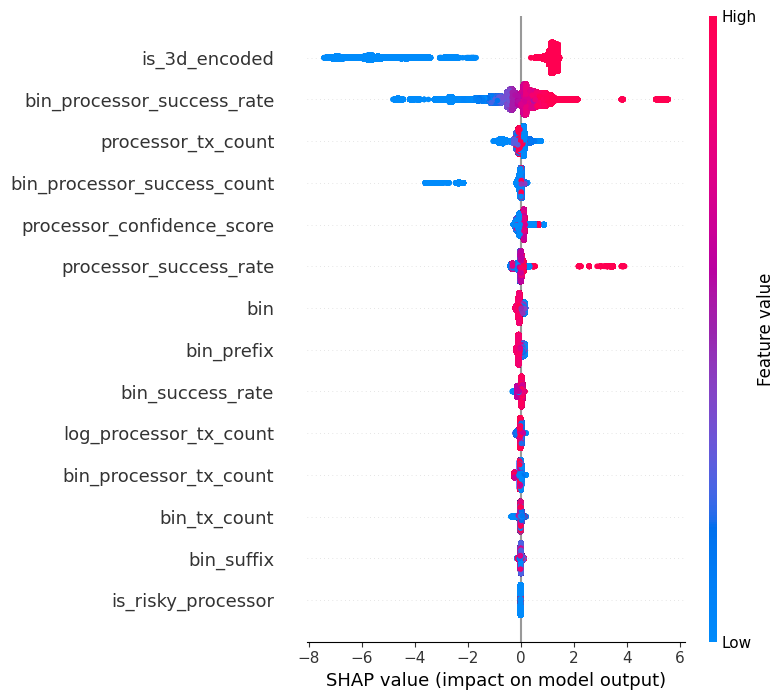

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Get feature importance
# importances = model.feature_importances_
# feature_names = X.columns

# # Sort and plot
# indices = np.argsort(importances)
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(indices)), importances[indices], align='center')
# plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
# plt.xlabel('Feature Importance')
# plt.title('XGBoost Feature Importance (Gain)')
# plt.tight_layout()
# plt.show()

# import shap
# explainer = shap.Explainer(model)
# shap_values = explainer(X)

# shap.summary_plot(shap_values, X)  # Top-down beeswarm plot



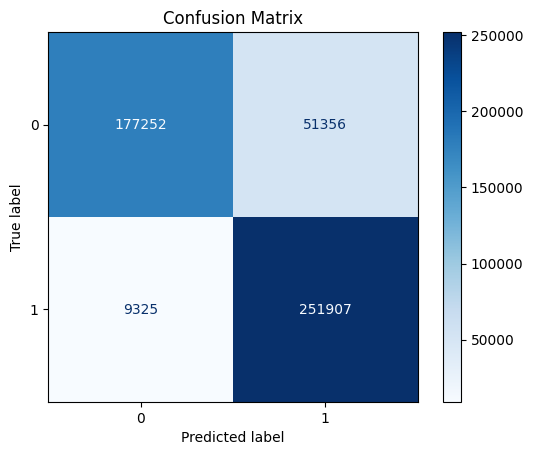

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred = model.predict(X_test)

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


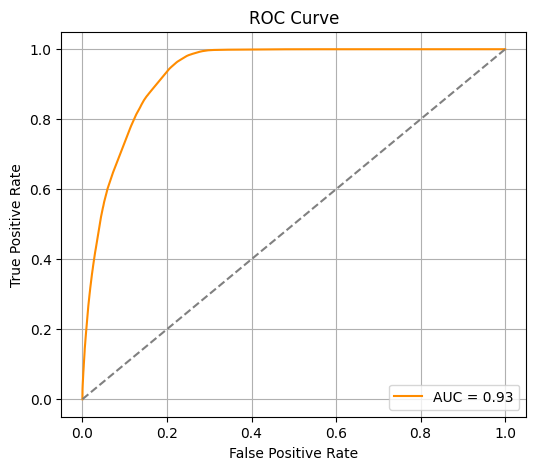

In [7]:
from sklearn.metrics import roc_curve, auc

# Get probabilities
y_scores = model.predict_proba(X_test)[:, 1]

# Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


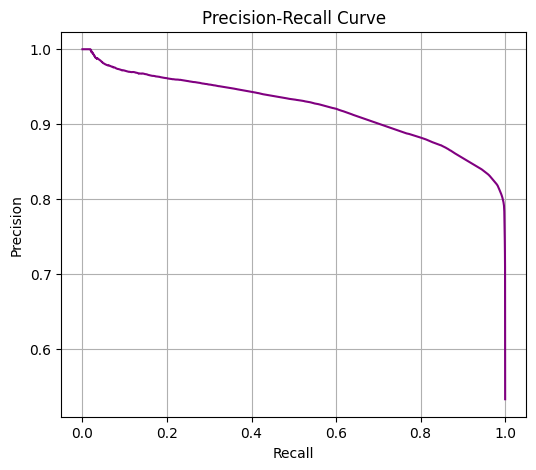

In [8]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


In [4]:
import pandas as pd
import pickle
import json

# Load model and stats
with open("processor_success_model.pkl", "rb") as f_model, \
     open("processor_success_stats.pkl", "rb") as f_stats, \
     open("processor_name_mapping.json", "r") as f_map:

    model = pickle.load(f_model)
    stats = pickle.load(f_stats)
    processor_name_map = json.load(f_map)

# Reverse the mapping: {0: "TWP"} etc.
reverse_processor_map = {v: k for k, v in processor_name_map.items()}

# Modified prediction function
def predict_top_processors(bin_number, is_3d_encoded, model, stats, processor_name_map, top_n=3, threshold=0.80):
    external_processors = {
        "TWP", "TWP (US)", "Fin - MID 01", "Npay", "Dreamzpay - Altitudepay"
    }

    bin_prefix = bin_number // 1000
    bin_suffix = bin_number % 1000

    rows = []
    for processor_id in stats["all_processors"]:
        bin_stats = stats["bin_tx"].get(bin_number, {})
        bin_success = stats["bin_success"].get(bin_number, {}).get("bin_success_rate", 0.0)
        proc_success = stats["proc_success"].get(processor_id, {}).get("processor_success_rate", 0.0)
        bin_proc_stats = stats["bin_proc_stats"].get((bin_number, processor_id), {})

        row = {
            "bin": bin_number,
            "bin_prefix": bin_prefix,
            "bin_suffix": bin_suffix,
            "is_3d_encoded": is_3d_encoded,
            "bin_tx_count": bin_stats.get("bin_tx_count", 0),
            "bin_success_rate": bin_success,
            "processor_success_rate": proc_success,
            "bin_processor_tx_count": bin_proc_stats.get("bin_processor_tx_count", 0),
            "bin_processor_success_count": bin_proc_stats.get("bin_processor_success_count", 0),
            "bin_processor_success_rate": bin_proc_stats.get("bin_processor_success_rate", 0.0)
        }
        rows.append((processor_id, row))

    df_pred = pd.DataFrame([r[1] for r in rows])
    probabilities = model.predict_proba(df_pred)[:, 1]

    # Convert to processor names using reverse map
    results = sorted(
        [{
            "processor": reverse_processor_map.get(r[0], f"Unknown ID {r[0]}"),
            "predicted_success": prob
        } for r, prob in zip(rows, probabilities)],
        key=lambda x: x["predicted_success"],
        reverse=True
    )

    internal = [r for r in results if r["processor"] not in external_processors and r["predicted_success"] >= threshold]
    external = [r for r in results if r["processor"] in external_processors]

    return (internal if internal else external)[:top_n]



In [5]:
# Predict top processors by name
bin_number = 462263
is_3d_encoded = 1

top_processors = predict_top_processors(
    bin_number, is_3d_encoded, model, stats, processor_name_map
)

# Show results
print("💡 Recommended Processors:")
for i, rec in enumerate(top_processors, 1):
    print(f"{i}. {rec['processor']} → Predicted Success: {rec['predicted_success']:.2%}")


ValueError: feature_names mismatch: ['bin', 'bin_prefix', 'bin_suffix', 'is_3d_encoded', 'bin_tx_count', 'bin_success_rate', 'processor_success_rate', 'processor_tx_count', 'log_processor_tx_count', 'processor_confidence_score', 'is_risky_processor', 'bin_processor_tx_count', 'bin_processor_success_count', 'bin_processor_success_rate'] ['bin', 'bin_prefix', 'bin_suffix', 'is_3d_encoded', 'bin_tx_count', 'bin_success_rate', 'processor_success_rate', 'bin_processor_tx_count', 'bin_processor_success_count', 'bin_processor_success_rate']
expected log_processor_tx_count, processor_confidence_score, processor_tx_count, is_risky_processor in input data